In [1]:
from math import sqrt,exp,pi,cos,sin
from random import randint,random
import matplotlib.pyplot as plt
import numpy as np
import json
#from multiprocessing import Pool
#import time

In [ ]:
class site():

    def __init__(self,x,y,z,t,n):
        self.Flinks = [1 + 0j]*n
        self.Blinks = [1 +0j]*n
        self.x = x
        self.y = y
        self.z = z
        self.t = t
        self.nsite = []
        self.bsite = []
    
    def Fconnect(self, site):
        self.nsite.append(site)
    
    def Bconnect(self, site):
        self.bsite.append(site)
        

In [ ]:
def create_lattice(Nx, Ny, Nz, Nt, n):
    Lattice = []
    for i in range(Nx):
        temp = []
        for j in range(Ny):
            temp2 = []
            for k in range(Nz):
                temp3 = []
                for t in range(Nt):
                    s = site(i, j, k, t, n)
                    temp3.append(s)
                temp2.append(temp3)
            temp.append(temp2)
        Lattice.append(temp)
        
    for i in range(Nx):
        for j in range(Ny):
            for k in range(Nz):
                for t in range(Nt):
                    Lattice[i][j][k][t].Fconnect(Lattice[(i+1)%Nx][j][k][t])
                    Lattice[i][j][k][t].Fconnect(Lattice[i][(j+1)%Ny][k][t])
                    Lattice[i][j][k][t].Fconnect(Lattice[i][j][(k+1)%Nz][t])
                    Lattice[i][j][k][t].Fconnect(Lattice[i][j][k][(t+1)%Nt])
                    Lattice[i][j][k][t].Bconnect(Lattice[(i-1 + Nx)%Nx][j][k][t])
                    Lattice[i][j][k][t].Bconnect(Lattice[i][(j-1+Ny)%Ny][k][t])
                    Lattice[i][j][k][t].Bconnect(Lattice[i][j][(k-1 + Nz)%Nz][t])
                    Lattice[i][j][k][t].Bconnect(Lattice[i][j][k][(t-1 + Nt)%Nt])
                    
            
            
    return Lattice        

In [ ]:
def dS(site, dire, newlink, n , Lattice, beta ):
    L = Lattice
    sold = 0
    snew = 0
    s = site
    d = dire
    for i in range(n):
        if i != dire:
            sold += 1 - s.Flinks[d]*s.nsite[d].Flinks[i]*complex.conjugate(s.nsite[i].Flinks[d])*complex.conjugate(s.Flinks[i])
            sold += 1 - complex.conjugate(s.Flinks[d])*complex.conjugate(s.bsite[i].Flinks[i])*s.bsite[i].Flinks[d]*s.bsite[i].nsite[d].Flinks[i]  
            snew += 1 - newlink*s.nsite[d].Flinks[i]*complex.conjugate(s.nsite[i].Flinks[d])*complex.conjugate(s.Flinks[i])
            snew += 1 - complex.conjugate(newlink)*complex.conjugate(s.bsite[i].Flinks[i])*s.bsite[i].Flinks[d]*s.bsite[i].nsite[d].Flinks[i]
            
    return beta*(snew.real - sold.real)

In [ ]:
def placq(site, dir1, dir2):
    s = site
    d1 = dir1
    d2 = dir2
    pl = 0
    pl += 1 - s.Flinks[d1]*s.nsite[d1].Flinks[d2]*complex.conjugate(s.nsite[d2].Flinks[d1])*complex.conjugate(s.Flinks[d2])
    return pl.real

In [ ]:
def S_per_plq(Lattice, Nx, Ny, Nz, Nt, beta):
    S = 0
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                for t in range(Nt):
                    s = Lattice[x][y][z][t]
                    S += placq(s, 0, 1)
                    S += placq(s, 0, 2)
                    S += placq(s, 0, 3)
                    S += placq(s, 1, 2)
                    S += placq(s, 1, 3)
                    S += placq(s, 2, 3)
    
    return S/(Nx*Ny*Nz*Nt*6)

In [ ]:
def S(Lattice, Nx, Ny, Nz, Nt, beta):
    S = 0
    for x in range(Nx):
        for y in range(Ny):
            for z in range(Nz):
                for t in range(Nt):
                    s = Lattice[x][y][z][t]
                    S += 1 - placq(s, 0, 1)
                    S += 1- placq(s, 0, 2)
                    S += 1 - placq(s, 0, 3)
                    S += 1 - placq(s, 1, 2)
                    S += 1 - placq(s, 1, 3)
                    S += 1 - placq(s, 2, 3)
    
    return -beta*S

In [ ]:
def Metropolis(Lattice, Nx,Ny,Nz,Nt, n, n_sweep, beta):
    Action = []
    Act_per_pl = []
    
    #initialize#
    h = 1
    idrate = 0.8
    ####
    
    for ns in range(n_sweep):
        accrate = 0
        for num in range(n):
            for i in range(Nx):
                for k in range(Ny):
                    for t in range(Nz):
                        for j in range(Nt):
                            x = randint(0, Nx-1)
                            y = randint(0, Ny-1)
                            z = randint(0, Nz-1)
                            t1 = randint(0, Nt-1)
                            dire = randint(0, n-1)
                            s = Lattice[x][y][z][t1]
                            th =   h*(random() - 0.5)%(2*pi)
                            X = cos(th) + 1j*sin(th)
                            newlink = X*s.Flinks[dire]
                            newlink = newlink/abs(newlink)
                            if random() <= min(1, exp(-dS(s, dire, newlink, n, Lattice, beta))):
                            #print(newlink, s.Flinks[dire], dS(s, dire, newlink, n, Lattice, a))
                                s.Flinks[dire] = newlink
                                s.nsite[dire].Blinks[dire] = complex.conjugate(newlink)
                                accrate = accrate + 1/(Nx*Ny*Nz*Nt*n)
        h = h*accrate/idrate
        
        #print(h, accrate)
        
        Action.append(S(Lattice, Nx, Ny,Nz, Nt, beta))
        Act_per_pl.append(S_per_plq(Lattice, Nx, Ny, Nz, Nt, beta))
    
    return Action, Act_per_pl 
            
            

In [ ]:
beta = [i*0.1 for i in range(2, 20)]   
n_sweep = 1500
Actiperplq = []
Action = []
for bt in beta:
    Lattice = create_lattice(Nx =8, Ny=8, Nz=8, Nt=8, n=4)
    data = Metropolis(Lattice, 8, 8, 8, 8, 4, n_sweep, bt)
    Actiperplq.append(data[1])
    Action.append(data[0])
    


In [ ]:
with open('met_data.txt', 'w') as f:
    f.write(json.dumps(Actiperplq))
    

In [ ]:
with open('met_data2.txt', 'w') as f:
    f.write(json.dumps(Action))

In [2]:
with open('met_data.txt', 'r') as f:
    Actiperplq = json.loads(f.read())
with open('met_data2.txt', 'r') as f:
    Action = json.loads(f.read())

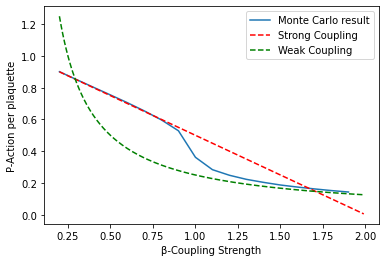

In [20]:
beta = [i*0.1 for i in range(2, 20)]   
plt.plot(beta,[np.mean(Act[200:])/6 for Act in Actiperplq], label = "Monte Carlo result" )
b = np.arange(0.2, 2., 0.01)
str_coup = [1- bt/2 for bt in b]
weak_coup = [(1/(4*bt)) for bt in b]
plt.plot(b, str_coup, 'r--',label = "Strong Coupling")
plt.plot(b, weak_coup, 'g--',label = "Weak Coupling")
plt.xlabel("β-Coupling Strength");
plt.ylabel("P-Action per plaquette");
plt.legend()
plt.show()


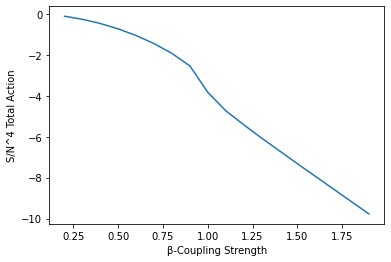

In [9]:
plt.plot(beta,[np.mean(S[200:])/(8*8*8*8) for S in Action] )
plt.xlabel("β-Coupling Strength");
plt.ylabel("S/N^4 Total Action");

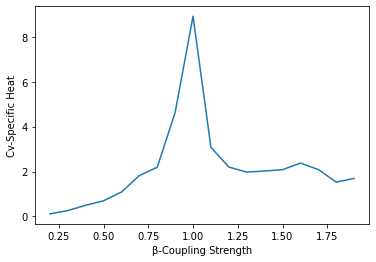

In [8]:
plt.plot(beta,[(np.std(S[200:])**2)/(8*8*8*8) for S in Action] )
plt.xlabel("β-Coupling Strength");
plt.ylabel("Cv-Specific Heat");